In [6]:
import numpy as np
from matplotlib import pyplot as plt

In [7]:
import pymc3 as pm

In [166]:
number_data_point = 1000
innovation_mean = 2 # this is the c term
innovation_std = 1 # this is the standard deviation of the innovation term
tao = 10
mean_intensity = innovation_mean / (1 - np.exp(-1/tao)) # this is the expectation value of all intensity signals
variance_intensity = innovation_std**2 / (1 - np.exp(-2/tao)) # this is the expectation value of all intensity signals
X = mean_intensity*np.ones(number_data_point) #initialize data matrix

print('The mean intensity is {}'.format(mean_intensity))
print('The variance of intensity is {}'.format(variance_intensity))
print('variance normalized by mean-squared is {}'.format(variance_intensity/mean_intensity**2))

The mean intensity is 21.016663889550088
The variance of intensity is 5.516655566126993
variance normalized by mean-squared is 0.012489593739470005


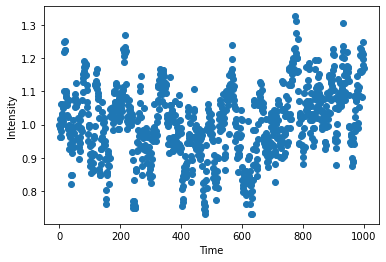

In [169]:
#Generate model data
phi = np.exp(-1/tao)
innovation = np.random.normal(loc=0.0, scale=innovation_std, size = number_data_point)

for i in np.arange(number_data_point-1):
    X[i+1]= innovation_mean + phi*X[i] + innovation[i] # Data not normalized
    
X_normalized = X/mean_intensity

#Plot model data
plt.plot(np.arange(number_data_point),X_normalized,'o')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.show()

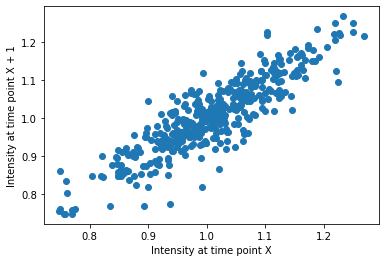

In [175]:
#Correlation between neighboring pts
averaged_pts = 400 
pth_neighbor = 1
plt.plot(X_normalized[0:averaged_pts],X_normalized[pth_neighbor:pth_neighbor+averaged_pts],'o')
plt.xlabel('Intensity at time point X')
#plt.ylabel('$X_{t+1}$'.format(pth_neighbor))
plt.ylabel('Intensity at time point X + {}'.format(pth_neighbor))
plt.show()

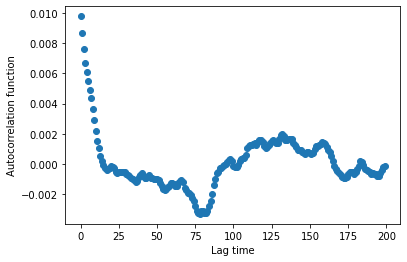

In [180]:
# Autocorrelation function
longest_lag_time = 200
lag_time = np.arange(longest_lag_time)
averaged_pts = 400 #Need averaged_pts+lognes_lag_time < number_data_point
Intensity_matrix = np.zeros([longest_lag_time,averaged_pts])
Correlation_matrix = np.zeros([longest_lag_time,averaged_pts])

for i in lag_time:
    Intensity_matrix[i] = X_normalized[i:i+averaged_pts] 
    Correlation_matrix[i] = Intensity_matrix[0]*Intensity_matrix[i]

Autocorrelation = np.average(Correlation_matrix, axis = 1) / (np.average(Intensity_matrix[0])*np.average(Intensity_matrix, axis = 1)) - 1
                                                          
plt.plot(lag_time,Autocorrelation,'o')   
plt.xlabel('Lag time')
plt.ylabel('Autocorrelation function')
plt.show()

In [158]:
pm.AR1?

Init signature: pm.AR1(k, tau_e, *args, **kwargs)
Docstring:     
Autoregressive process with 1 lag.

Parameters
----------
k: tensor
   effect of lagged value on current value
tau_e: tensor
   precision for innovations
File:           ~/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/pymc3/distributions/timeseries.py
Type:           type
Subclasses:     


In [ ]:
with pm.Model() as ar1:
    # assumes 95% of prob mass is between -2 and 2
    theta = pm.Normal("theta", 0.0, 1.0)
    # precision of the innovation term
    tau = pm.Exponential("tau", 0.5)
    # process mean
    center = pm.Normal("center", mu=0.0, sigma=1.0)

    likelihood = pm.AR1("y", k=theta, tau_e=tau, observed=y - center)

    trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
    idata = az.from_pymc3(trace)